# Importing

In [64]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
import xgboost as xgb

In [65]:
train = pd.read_csv("titanic3.csv")

# Summarizing the data

Check for missing data first.

In [66]:
train.isnull().sum()

pclass          0
survived        0
name            0
sex             0
age           263
sibsp           0
parch           0
ticket          0
fare            1
cabin        1014
embarked        2
boat          823
body         1188
home.dest     564
dtype: int64

In [67]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
pclass       1309 non-null int64
survived     1309 non-null int64
name         1309 non-null object
sex          1309 non-null object
age          1046 non-null float64
sibsp        1309 non-null int64
parch        1309 non-null int64
ticket       1309 non-null object
fare         1308 non-null float64
cabin        295 non-null object
embarked     1307 non-null object
boat         486 non-null object
body         121 non-null float64
home.dest    745 non-null object
dtypes: float64(3), int64(4), object(7)
memory usage: 143.2+ KB


In [68]:
train.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881138,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413493,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


In [69]:
#body is an id assigned to bodies found
train.drop('body', axis = 1, inplace = True)

In [70]:
train.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,2,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,11,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,NaN,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,NaN,"Montreal, PQ / Chesterville, ON"


# Feature engineering

In [71]:
pd.value_counts(train['cabin'], dropna = False)[0:20]

NaN                1014
C23 C25 C27           6
G6                    5
B57 B59 B63 B66       5
C78                   4
D                     4
C22 C26               4
B96 B98               4
F33                   4
F4                    4
F2                    4
B58 B60               3
C101                  3
B51 B53 B55           3
A34                   3
E101                  3
E34                   3
C6                    2
C85                   2
C83                   2
Name: cabin, dtype: int64

In [72]:
cabin_split = train['cabin'].str.split('(\d+)')

def find_letter(entry) :
    
        if entry is np.nan:
            return "unknown"
        else: 
            for item in entry: 
                if item.isalpha():
                    return item
                
print(train['cabin'][0:9])
print(cabin_split[0:9])
cabin_letter = cabin_split.apply(find_letter)
train['cabin_letter'] = (cabin_letter)

0         B5
1    C22 C26
2    C22 C26
3    C22 C26
4    C22 C26
5        E12
6         D7
7        A36
8       C101
Name: cabin, dtype: object
0             [B, 5, ]
1    [C, 22,  C, 26, ]
2    [C, 22,  C, 26, ]
3    [C, 22,  C, 26, ]
4    [C, 22,  C, 26, ]
5            [E, 12, ]
6             [D, 7, ]
7            [A, 36, ]
8           [C, 101, ]
Name: cabin, dtype: object


In [73]:
cabin_split2 = train['cabin'].str.split('([0-9]+)')
cabin_split2[994]


['F E', '46', '']

In [74]:
# function for extracting letters or numbers

def find_info(entry, number = True ) :
    
        numbers = []
        
        if number is True: 
            if entry is np.nan:
                return 0
            else:
                for item in entry: 
                    if item.isnumeric():
                        numbers.append(float(item))
                    else:
                        numbers.append(0)
            return np.mean(numbers)
        
        else: 
            if entry is np.nan:
                return "u"
            for item in entry: 
                if item[0].isalpha():
                    return item
                

In [75]:
cabin_number = cabin_split.apply(find_info, number = True)
cabin_letter = cabin_split.apply(find_info, number = False)
train['cabin_letter'] = (cabin_letter)
le = LabelEncoder()
le.fit(cabin_letter)
cabin_le = le.transform(cabin_letter)
zip_obj = zip(list(cabin_letter), cabin_le)

In [76]:
dict(list(zip_obj))

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'F E': 6,
 'F G': 7,
 'G': 8,
 'T': 9,
 'u': 10}

In [77]:
train['cabin_letter_le'] = cabin_le
train['cabin_number'] = cabin_number

In [78]:
train['family'] = train['sibsp'] + train['parch']

# Charts

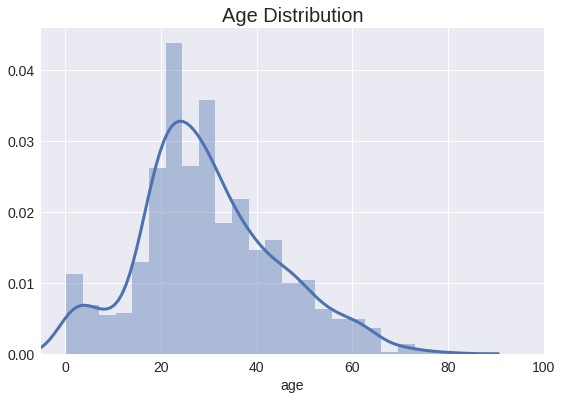

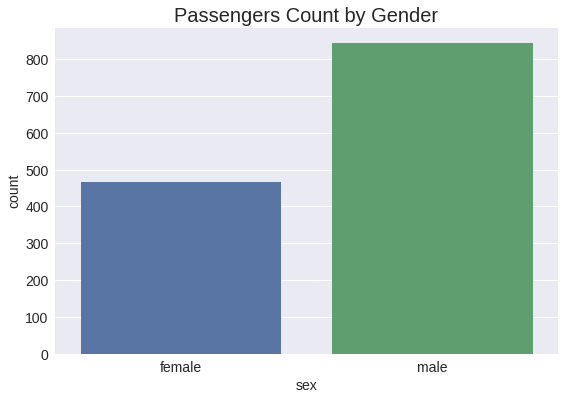

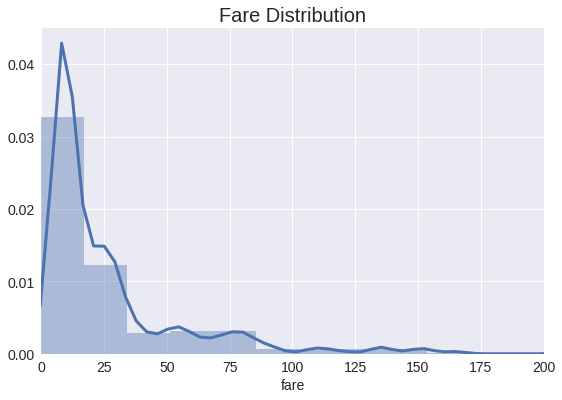

In [79]:
from pylab import rcParams
rcParams.update({'font.size' : 14, 'legend.fontsize' : "small", 
                 "xtick.labelsize" : 14, "ytick.labelsize" : 14, 
                 "figure.figsize":(9, 6), "axes.titlesize" : 20,
                 "axes.labelsize" : 14, "lines.linewidth" : 3, 
                 "lines.markersize" : 10
})
sns.set_style("darkgrid")

#fig=plt.figure(figsize=(8, 8), dpi= 150)
plt.title("Age Distribution")
sns.distplot(train['age'].dropna())
plt.xlim(-5,100)
plt.show()

#fig=plt.figure(figsize=(8, 5), dpi = 150, facecolor='w', edgecolor='k')
plt.title("Passengers Count by Gender")
sns.countplot('sex', data = train)
plt.show()

plt.title("Fare Distribution")
fare_plot = sns.distplot(train['fare'].dropna(), bins = 30)
fare_plot.set_xlim([0, 200])
plt.show()

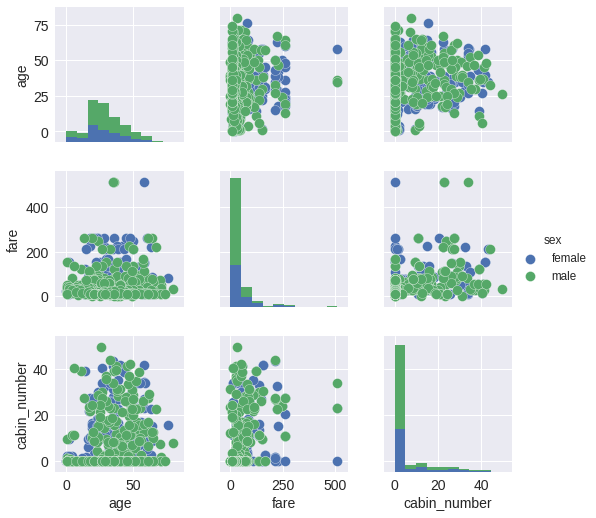

In [80]:
#fig=plt.figure(figsize=(16, 16), dpi= 300)
sns.pairplot(data = train[['age', 'fare', 'cabin_number', 'sex']].dropna(), hue = 'sex')
plt.show()

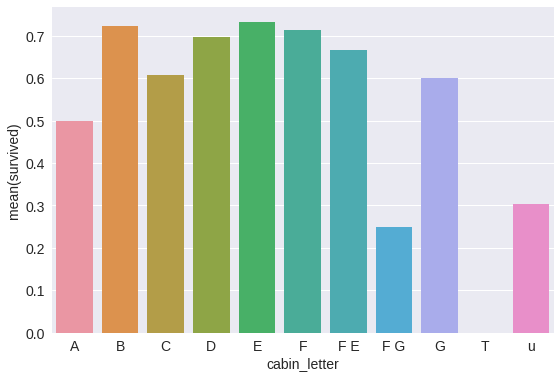

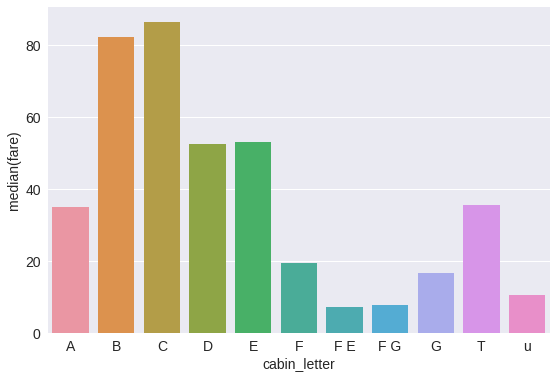

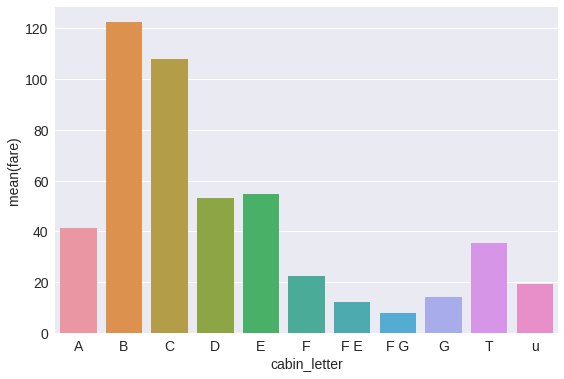

In [81]:

sns.barplot(x = "cabin_letter", y = "survived", data=train.sort_values('cabin_letter'), 
            ci = None)
plt.show()

sns.barplot(x = "cabin_letter", y = "fare", 
            data=train[train['cabin_letter'].notnull()].sort_values('cabin_letter'), 
            ci = None, estimator = np.median)
plt.show()

sns.barplot(x = "cabin_letter", y = "fare", 
            data=train[train['cabin_letter'].notnull()].sort_values('cabin_letter'), 
            ci = None)


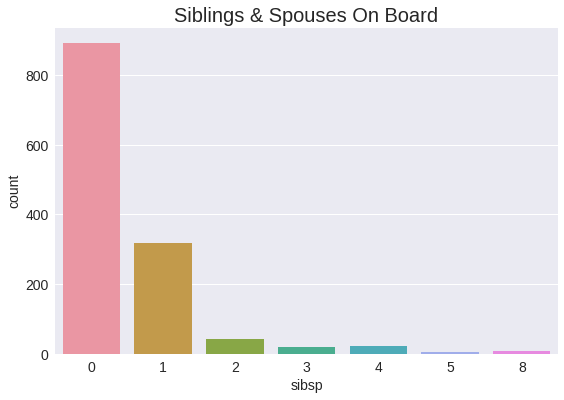

In [82]:

#fig=plt.figure(figsize=(8, 5), dpi = 150, facecolor='w', edgecolor='k')
plt.title("Siblings & Spouses On Board")
sns.countplot(train['sibsp'].dropna())
plt.show()


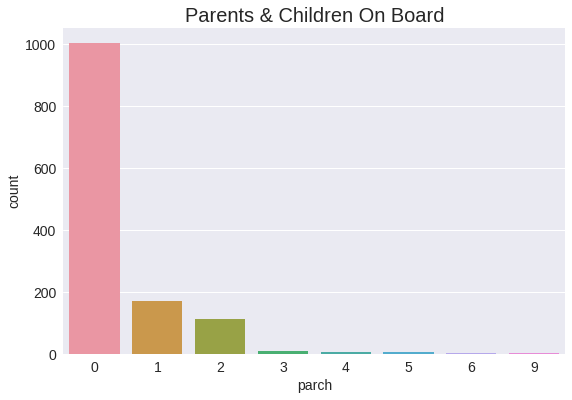

In [83]:
#fig=plt.figure(figsize=(8, 5), dpi = 150, facecolor='w', edgecolor='k')
plt.title("Parents & Children On Board")
sns.countplot(train['parch'].dropna())
plt.show()

# Preparing data

In [84]:
display(pd.pivot_table(train, index = ["embarked"]))

display(pd.pivot_table(train, index = ["sex"]))

,age,cabin_letter_le,cabin_number,family,fare,parch,pclass,sibsp,survived
embarked,,,,,,,,,
C,32.332170,6.503704,7.739777,0.770370,62.336267,0.370370,1.851852,0.400000,0.555556
Q,28.630000,9.715447,1.010840,0.455285,12.409012,0.113821,2.894309,0.341463,0.357724
S,29.245205,8.650985,2.961207,0.977024,27.418824,0.426696,2.347921,0.550328,0.332604


,age,cabin_letter_le,cabin_number,family,fare,parch,pclass,sibsp,survived
sex,,,,,,,,,
female,28.687088,7.733906,4.986205,1.285408,46.198097,0.633047,2.154506,0.652361,0.727468
male,30.585228,8.607355,3.102860,0.661922,26.154601,0.247924,2.372479,0.413998,0.190985


In [85]:
# Convert the male and female groups to integer form

train["sex"][train["sex"] == "male"] = 0
train["sex"][train["sex"] == "female"] = 1

# Impute the Embarked variable
train["embarked"] = train["embarked"].fillna("S")

# Convert the Embarked classes to integer form
train["embarked"][train["embarked"] == "S"] = 0
train["embarked"][train["embarked"] == "C"] = 1
train["embarked"][train["embarked"] == "Q"] = 2

/home/ryeyoo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ryeyoo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/ryeyoo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Rem

In [86]:
train.head(6)
#train["Pclass"][0:5]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,home.dest,cabin_letter,cabin_letter_le,cabin_number,family
0,1,1,"Allen, Miss. Elisabeth Walton",1,29.00,0,0,24160,211.3375,B5,0,2,"St Louis, MO",B,1,1.666667,0
1,1,1,"Allison, Master. Hudson Trevor",0,0.92,1,2,113781,151.5500,C22 C26,0,11,"Montreal, PQ / Chesterville, ON",C,2,9.600000,3
2,1,0,"Allison, Miss. Helen Loraine",1,2.00,1,2,113781,151.5500,C22 C26,0,NaN,"Montreal, PQ / Chesterville, ON",C,2,9.600000,3
3,1,0,"Allison, Mr. Hudson Joshua Creighton",0,30.00,1,2,113781,151.5500,C22 C26,0,NaN,"Montreal, PQ / Chesterville, ON",C,2,9.600000,3
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1,25.00,1,2,113781,151.5500,C22 C26,0,NaN,"Montreal, PQ / Chesterville, ON",C,2,9.600000,3
5,1,1,"Anderson, Mr. Harry",0,48.00,0,0,19952,26.5500,E12,0,3,"New York, NY",E,4,4.000000,0


In [87]:
dummy_vars = pd.get_dummies(train['pclass'], prefix = "class")
print(dummy_vars[0:6])

   class_1  class_2  class_3
0        1        0        0
1        1        0        0
2        1        0        0
3        1        0        0
4        1        0        0
5        1        0        0


In [88]:
train.shape

(1309, 17)

In [89]:
train_processed = train.join(dummy_vars) 

In [90]:

train_processed.loc[1:3,]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,home.dest,cabin_letter,cabin_letter_le,cabin_number,family,class_1,class_2,class_3
1,1,1,"Allison, Master. Hudson Trevor",0,0.92,1,2,113781,151.55,C22 C26,0,11,"Montreal, PQ / Chesterville, ON",C,2,9.6,3,1,0,0
2,1,0,"Allison, Miss. Helen Loraine",1,2.00,1,2,113781,151.55,C22 C26,0,NaN,"Montreal, PQ / Chesterville, ON",C,2,9.6,3,1,0,0
3,1,0,"Allison, Mr. Hudson Joshua Creighton",0,30.00,1,2,113781,151.55,C22 C26,0,NaN,"Montreal, PQ / Chesterville, ON",C,2,9.6,3,1,0,0


In [91]:
train_processed = train_processed[train_processed.fare.notnull()]
train_processed['sex'] = train_processed['sex'].astype('int')
feature_columns_to_use =  ["pclass", 'sex', 'parch', 'sibsp', 'fare', 'cabin_letter_le', 'cabin_number']
#train_x = train_processed[feature_columns_to_use]
#train_y = train_processed["survived"].values

In [92]:
train_processed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1308 entries, 0 to 1308
Data columns (total 20 columns):
pclass             1308 non-null int64
survived           1308 non-null int64
name               1308 non-null object
sex                1308 non-null int64
age                1045 non-null float64
sibsp              1308 non-null int64
parch              1308 non-null int64
ticket             1308 non-null object
fare               1308 non-null float64
cabin              295 non-null object
embarked           1308 non-null object
boat               486 non-null object
home.dest          745 non-null object
cabin_letter       1308 non-null object
cabin_letter_le    1308 non-null int64
cabin_number       1308 non-null float64
family             1308 non-null int64
class_1            1308 non-null uint8
class_2            1308 non-null uint8
class_3            1308 non-null uint8
dtypes: float64(3), int64(7), object(7), uint8(3)
memory usage: 187.8+ KB


## splitting train and test for cv

In [93]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(train_processed[feature_columns_to_use], 
                                                    train_processed['survived'], test_size = .3, random_state = 42)

In [94]:
test_x.shape

(393, 7)

In [95]:
train_x.loc[:,'sex'] = train_x.loc[:,'sex'].astype('int')
train_x.isnull().sum()



pclass             0
sex                0
parch              0
sibsp              0
fare               0
cabin_letter_le    0
cabin_number       0
dtype: int64

In [96]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 915 entries, 1213 to 1126
Data columns (total 7 columns):
pclass             915 non-null int64
sex                915 non-null int64
parch              915 non-null int64
sibsp              915 non-null int64
fare               915 non-null float64
cabin_letter_le    915 non-null int64
cabin_number       915 non-null float64
dtypes: float64(2), int64(5)
memory usage: 57.2 KB


In [97]:
train_x_matrix = train_x.as_matrix()


# Models

## logistic

In [98]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

In [99]:
train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 915 entries, 1213 to 1126
Data columns (total 7 columns):
pclass             915 non-null int64
sex                915 non-null int64
parch              915 non-null int64
sibsp              915 non-null int64
fare               915 non-null float64
cabin_letter_le    915 non-null int64
cabin_number       915 non-null float64
dtypes: float64(2), int64(5)
memory usage: 57.2 KB


In [100]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model = model.fit(X = train_x_matrix, y = train_y)
print(model.score(X = train_x_matrix, y = train_y))



0.795628415301


# random forest

In [101]:
from sklearn.ensemble import RandomForestClassifier
#train["Sex"] = train['Sex'].astype('category')
#train["Pclass"] = train['Pclass'].astype('category')
#rf_model = RandomForestClassifier().fit(train[['Pclass', 'Sex', 'Parch', 'Fare']], train_y)
rf_model = RandomForestClassifier(n_estimators = 500, random_state=42).fit(train_x_matrix, train_y)
rf_model.score(train_x_matrix, train_y)

#rf_model.score(train[['Pclass', 'Sex', 'Parch', 'Fare']], train_y)

0.93224043715846994

# support vector machines

In [102]:
from sklearn.svm import SVC

svm_m = SVC(kernel = "rbf", C = 100, probability = True).fit(train_x_matrix, train_y)
svm_m.score(train_x_matrix, train_y)

0.9027322404371585

In [103]:
params = {'gamma':np.random.uniform(0, 1, 20)}

## xgboost (gradient boosted trees)

In [104]:
model_xgb = XGBClassifier(
  learning_rate =0.01,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=5,
 gamma=0.00,
 subsample=0.9,
 colsample_bytree=0.8,
 reg_alpha=0.05,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

xgb_result1 = model_xgb.fit(train_processed[["pclass", 'sex', 'parch', 'sibsp', 'fare', 'cabin_letter_le', 'cabin_number']], train_processed['survived'])
xgb_result1.score(train_x, train_y)

0.86120218579234975

## Tuning xgb

In [105]:
def modelfit(alg, dtrain, predictors, target, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=['auc','logloss'], early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='logloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % accuracy_score(dtrain[target].values, dtrain_predictions))
    print("AUC Score (Train): %f" % roc_auc_score(dtrain[target], dtrain_predprob))
    print("logloss :{}".format(log_loss(dtrain[target], dtrain_predprob)))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

/home/ryeyoo/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ryeyoo/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Model Report
Accuracy : 0.8631
AUC Score (Train): 0.927370
logloss :0.34351686833266865


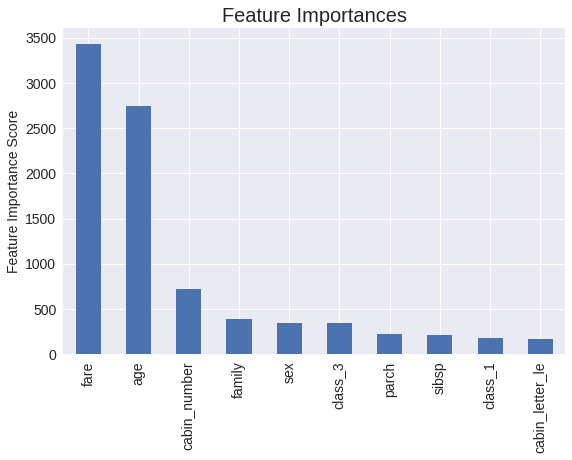

In [106]:
model_xgb1 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=9,
 min_child_weight=5,
 gamma=0.00,
 subsample=0.9,
 colsample_bytree=0.8,
 reg_alpha=0.05,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

modelfit(model_xgb1, train_processed, ["class_3", "class_1", 'family', 'sex', 
                                       'parch', 'sibsp', 'fare', 'cabin_letter_le', 
                                       'cabin_number', 'age'], target = ['survived'])

/home/ryeyoo/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ryeyoo/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Model Report
Accuracy : 0.8685
AUC Score (Train): 0.929775
logloss :0.3386235861178909


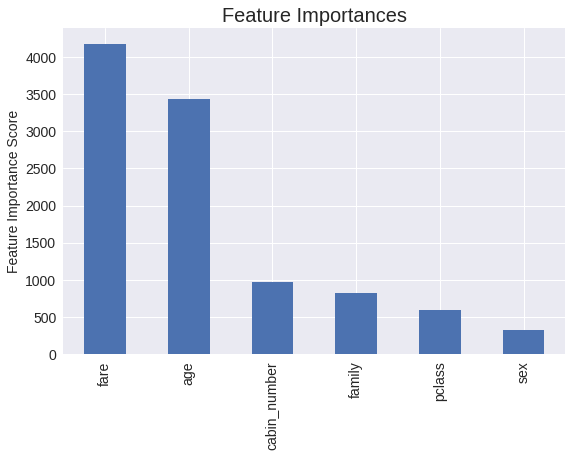

In [107]:
model_xgb1 = XGBClassifier(learning_rate =0.01, n_estimators=1000,
                             max_depth=9, min_child_weight=5,
                             gamma=0.00, subsample=0.9,
                             colsample_bytree=0.8, reg_alpha=0.05,
                             objective= 'binary:logistic', nthread=4,
                             scale_pos_weight=1, seed=27)

modelfit(model_xgb1, train_processed, ['age', 'pclass', 'family', 'sex', 'fare', 'cabin_number'], 
         target = ['survived'])

In [108]:
from sklearn.grid_search import GridSearchCV

cv_params = {'min_child_weight':[1,2,3,4,5,6,7,8], 'max_depth':[2,3,4,5,6,7,8,9], "gamma":[0,0.001,0.1,0.5,1]}


optimized_GBM = GridSearchCV(XGBClassifier(learning_rate =0.01, n_estimators=1000,
                             max_depth=4, min_child_weight=6,
                             gamma=0.05, subsample=0.9,
                             colsample_bytree=0.8, reg_alpha=0.05,
                             objective= 'binary:logistic', nthread=4,
                             scale_pos_weight=1, seed=27), cv_params, scoring = 'neg_log_loss', cv = 5, n_jobs = 3) 

In [109]:
optimized_GBM.fit(train_x, train_y)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0.05, learning_rate=0.01, max_delta_step=0, max_depth=4,
       min_child_weight=6, missing=None, n_estimators=1000, nthread=4,
       objective='binary:logistic', reg_alpha=0.05, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.9),
       fit_params={}, iid=True, n_jobs=3,
       param_grid={'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8], 'max_depth': [2, 3, 4, 5, 6, 7, 8, 9], 'gamma': [0, 0.001, 0.1, 0.5, 1]},
       pre_dispatch='2*n_jobs', refit=True, scoring='neg_log_loss',
       verbose=0)

In [110]:
#optimized_GBM.grid_scores_

In [111]:
print(optimized_GBM.best_score_)
print(optimized_GBM.best_params_)


-0.4394710524720165
{'gamma': 0, 'max_depth': 9, 'min_child_weight': 5}


# Evaluation

## logistic

In [112]:

predicted = model.predict(train_x_matrix)
predicted_prob = model.predict_proba(train_x_matrix)

#print(metrics.confusion_matrix(train_y, predicted))
#print(train_y.astype(float).mean())
#print(predicted.astype(int).mean())


print("auc: " + str(roc_auc_score(train_y, predicted)))
print("log loss: {}".format(log_loss(train_y, predicted_prob)))
print(classification_report(train_y, predicted))

auc: 0.77142351093
log loss: 0.4676643908944802
             precision    recall  f1-score   support

          0       0.82      0.86      0.84       578
          1       0.74      0.68      0.71       337

avg / total       0.79      0.80      0.79       915



## random forest

In [113]:
predicted_rf = rf_model.predict(test_x)
predicted_rf_prob = rf_model.predict_proba(test_x)
print("auc:" + str(roc_auc_score(test_y, predicted_rf)))
print("log loss: {}".format(log_loss(test_y, predicted_rf_prob)))
print(classification_report(test_y, predicted_rf))

auc:0.766577754068
log loss: 0.6139258637404342
             precision    recall  f1-score   support

          0       0.79      0.85      0.82       230
          1       0.77      0.68      0.72       163

avg / total       0.78      0.78      0.78       393



## svm

In [114]:
predicted_svm = svm_m.predict(test_x)
predicted_svm_prob = svm_m.predict_proba(test_x)
print("auc:" + str(roc_auc_score(test_y, predicted_svm)))
print("log loss: {}".format(log_loss(test_y, predicted_svm_prob)))
print(classification_report(test_y, predicted_svm))

auc:0.71389703921
log loss: 0.560307837249314
             precision    recall  f1-score   support

          0       0.76      0.77      0.76       230
          1       0.67      0.66      0.66       163

avg / total       0.72      0.72      0.72       393



## xgb

In [115]:
predicted_xgb = xgb_result1.predict(test_x)
predicted_xgb_proba = xgb_result1.predict_proba(test_x)
print("auc:" + str(roc_auc_score(test_y, predicted_xgb)))
print("log loss: {}".format(log_loss(test_y, predicted_xgb_proba)))
print(classification_report(test_y, predicted_xgb))

auc:0.839957321953
log loss: 0.36240311959905325
             precision    recall  f1-score   support

          0       0.85      0.91      0.88       230
          1       0.86      0.77      0.81       163

avg / total       0.85      0.85      0.85       393



# Digging into logistic models

## statsmodels logistic instead of sklearn

In [116]:
import statsmodels.api as sm


logit = sm.Logit(train_y.astype(float), train_x.astype(float))
#logit2 = sm.Logit(train_y.astype(float), train[['pclass', 'sex', 'Parch', 'Fare']].astype(float))

# fit the model
result = logit.fit()
#result2 = logit2.fit()

Optimization terminated successfully.
         Current function value: 0.467958
         Iterations 6


In [117]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               survived   No. Observations:                  915
Model:                          Logit   Df Residuals:                      908
Method:                           MLE   Df Model:                            6
Date:                Wed, 02 Aug 2017   Pseudo R-squ.:                  0.2889
Time:                        19:40:10   Log-Likelihood:                -428.18
converged:                       True   LL-Null:                       -602.11
                                        LLR p-value:                 4.435e-72
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
pclass             -0.4577      0.148     -3.097      0.002      -0.747      -0.168
sex                 2.6199      0.186     14.080      0.000       2.255       2.985
parch              -0.1223      0.102     -1.204      0.229      -0.321       0.077
sibsp              -0.2349      0.103     -2.284      0.022      -0.436      -0.033
fare                0.0037      0.002      1.675      0.094      -0.001       0.008
cabin_letter_le    -0.0672      0.039     -1.708      0.088      -0.144       0.010
cabin_number        0.0042      0.012      0.355      0.723      -0.019       0.027
===================================================================================
"""

In [118]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
log_model = smf.glm('survived ~ C(pclass) + fare + parch + C(sex)', 
        data = train, family = sm.families.Binomial()).fit()
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:               survived   No. Observations:                 1308
Model:                            GLM   Df Residuals:                     1302
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -627.75
Date:                Wed, 02 Aug 2017   Deviance:                       1255.5
Time:                        19:40:10   Pearson chi2:                 1.34e+03
No. Iterations:                     5                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.5051      0.191     -2.651      0.008      -0.879      -0.132
C(pclass)[T.2]    -0.7896      0.224     -3.530      0.000      -1.228      -0.351
C(pclass)[T.3]    -1.6108      0.210     -7.658      0.000      -2.023      -1.199
C(sex)[T.1]        2.5355      0.151     16.739      0.000       2.239       2.832
fare               0.0016      0.002      0.876      0.381      -0.002       0.005
parch             -0.0886      0.084     -1.055      0.291      -0.253       0.076
==================================================================================
"""

In [119]:
y = log_model.predict()
print(y.shape)
print(train_x.iloc[0:2,])
print(y[0:5])
print(predicted_prob[0:5,1])

(1308,)
      pclass  sex  parch  sibsp   fare  cabin_letter_le  cabin_number
1213       3    0      0      0   8.05               10           0.0
1208       3    1      2      3  27.90               10           0.0
[ 0.91377443  0.39042882  0.88993126  0.39042882  0.88993126]
[ 0.12069396  0.42790054  0.74530071  0.12064429  0.12063089]


## Interpreting results


In [120]:
# men labeled 0

print("ratio for men/women "  + str(np.exp(2.7112)))
print("ratio inc/dec for each parent/child " + str(np.exp((-0.1936))))

ratio for men/women 15.0473214709
ratio inc/dec for each parent/child 0.823987433332
